# 论文13：Attention Is All You Need
## Vaswani et al. (2017)

### Transformer：纯注意力架构

用自注意力机制取代 RNN 的革命性架构，为现代 LLM 奠定了基础。

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

## 缩放点积注意力

基础构建块：
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Attention output shape: (5, 8)
Attention weights shape: (5, 5)
Attention weights sum (should be 1): [1. 1. 1. 1. 1.]


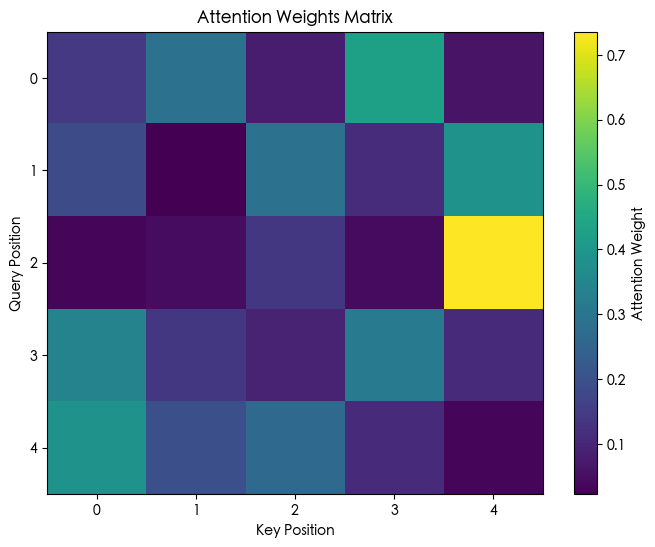

In [2]:
def softmax(x, axis=-1):
    """数值稳定的 softmax"""
    x_max = np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x - x_max)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    缩放点积注意力
    
    Q: Queries (seq_len_q, d_k)
    K: Keys (seq_len_k, d_k)
    V: Values (seq_len_v, d_v)
    mask: 可选的掩码 (seq_len_q, seq_len_k)
    """
    d_k = Q.shape[-1]
    
    # 计算注意力分数
    scores = np.dot(Q, K.T) / np.sqrt(d_k)
    
    # 如果提供了掩码则应用（用于因果性或填充）
    if mask is not None:
        scores = scores + (mask * -1e9)
    
    # Softmax 得到注意力权重
    attention_weights = softmax(scores, axis=-1)
    
    # 值的加权和
    output = np.dot(attention_weights, V)
    
    return output, attention_weights

# 测试缩放点积注意力
seq_len = 5
d_model = 8

Q = np.random.randn(seq_len, d_model)
K = np.random.randn(seq_len, d_model)
V = np.random.randn(seq_len, d_model)

output, attn_weights = scaled_dot_product_attention(Q, K, V)

print(f"Attention output shape: {output.shape}")
print(f"Attention weights shape: {attn_weights.shape}")
print(f"Attention weights sum (should be 1): {attn_weights.sum(axis=1)}")

# 可视化注意力模式
plt.figure(figsize=(8, 6))
plt.imshow(attn_weights, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.title('Attention Weights Matrix')
plt.show()

## 多头注意力

多个注意力"头"关注输入的不同方面：
$$\text{MultiHead}(Q,K,V) = \text{Concat}(head_1, ..., head_h)W^O$$

In [3]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # 所有头的 Q, K, V 线性投影（并行化）
        self.W_q = np.random.randn(d_model, d_model) * 0.1
        self.W_k = np.random.randn(d_model, d_model) * 0.1
        self.W_v = np.random.randn(d_model, d_model) * 0.1
        
        # 输出投影
        self.W_o = np.random.randn(d_model, d_model) * 0.1
    
    def split_heads(self, x):
        """分割为多个头: (seq_len, d_model) -> (num_heads, seq_len, d_k)"""
        seq_len = x.shape[0]
        x = x.reshape(seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 0, 2)
    
    def combine_heads(self, x):
        """合并头: (num_heads, seq_len, d_k) -> (seq_len, d_model)"""
        seq_len = x.shape[1]
        x = x.transpose(1, 0, 2)
        return x.reshape(seq_len, self.d_model)
    
    def forward(self, Q, K, V, mask=None):
        """
        多头注意力前向传播
        
        Q, K, V: (seq_len, d_model)
        """
        # 线性投影
        Q = np.dot(Q, self.W_q.T)
        K = np.dot(K, self.W_k.T)
        V = np.dot(V, self.W_v.T)
        
        # 分割为多个头
        Q = self.split_heads(Q)  # (num_heads, seq_len, d_k)
        K = self.split_heads(K)
        V = self.split_heads(V)
        
        # 对每个头应用注意力
        head_outputs = []
        self.attention_weights = []
        
        for i in range(self.num_heads):
            head_out, head_attn = scaled_dot_product_attention(
                Q[i], K[i], V[i], mask
            )
            head_outputs.append(head_out)
            self.attention_weights.append(head_attn)
        
        # 堆叠头
        heads = np.stack(head_outputs, axis=0)  # (num_heads, seq_len, d_k)
        
        # 合并头
        combined = self.combine_heads(heads)  # (seq_len, d_model)
        
        # 最终线性投影
        output = np.dot(combined, self.W_o.T)
        
        return output

# 测试多头注意力
d_model = 64
num_heads = 8
seq_len = 10

mha = MultiHeadAttention(d_model, num_heads)

X = np.random.randn(seq_len, d_model)
output = mha.forward(X, X, X)  # Self-attention

print(f"\nMulti-Head Attention:")
print(f"Input shape: {X.shape}")
print(f"Output shape: {output.shape}")
print(f"Number of heads: {num_heads}")
print(f"Dimension per head: {mha.d_k}")


Multi-Head Attention:
Input shape: (10, 64)
Output shape: (10, 64)
Number of heads: 8
Dimension per head: 8


## 位置编码

由于 Transformer 没有循环结构，我们需要添加位置信息：
$$PE_{(pos, 2i)} = \sin(pos / 10000^{2i/d_{model}})$$
$$PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i/d_{model}})$$

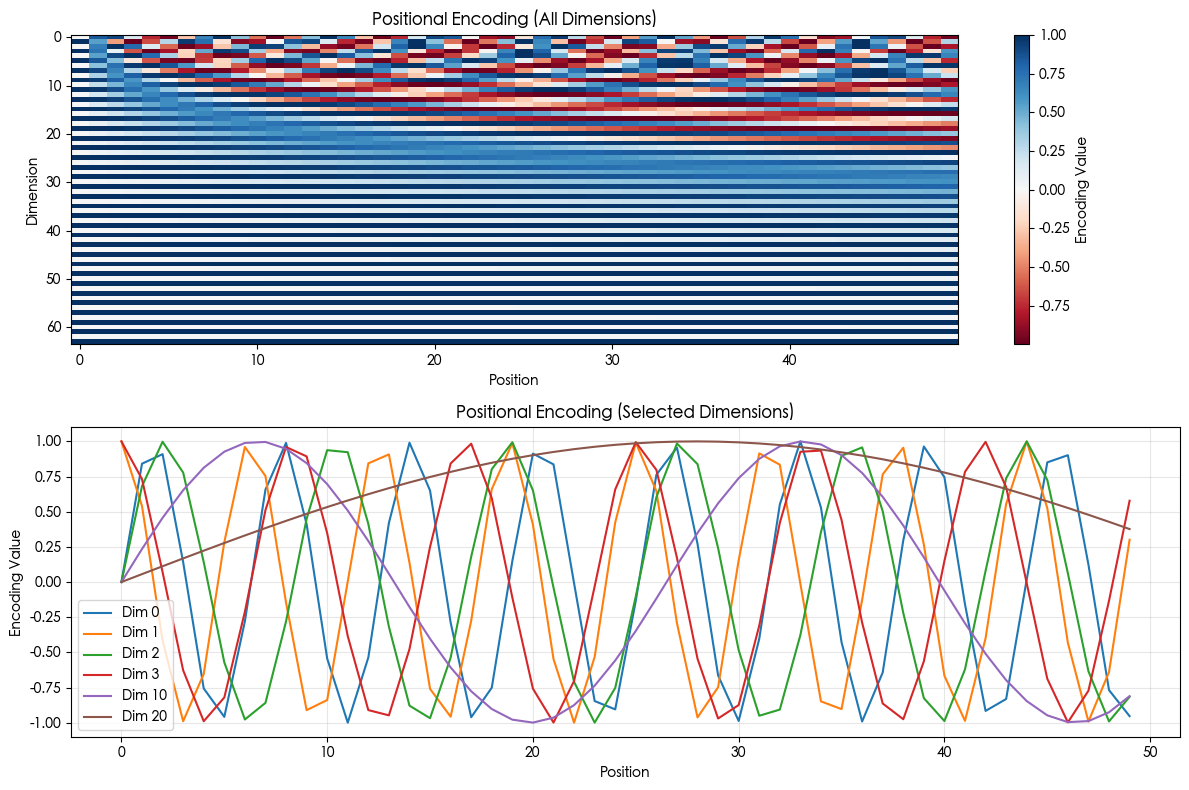

Positional encoding shape: (50, 64)
不同频率在不同尺度上编码位置信息


In [4]:
def positional_encoding(seq_len, d_model):
    """
    创建正弦位置编码
    """
    pe = np.zeros((seq_len, d_model))
    
    position = np.arange(0, seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    # 对偶数索引应用 sin
    pe[:, 0::2] = np.sin(position * div_term)
    
    # 对奇数索引应用 cos
    pe[:, 1::2] = np.cos(position * div_term)
    
    return pe

# 生成位置编码
seq_len = 50
d_model = 64
pe = positional_encoding(seq_len, d_model)

# 可视化位置编码
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.imshow(pe.T, cmap='RdBu', aspect='auto')
plt.colorbar(label='Encoding Value')
plt.xlabel('Position')
plt.ylabel('Dimension')
plt.title('Positional Encoding (All Dimensions)')

plt.subplot(2, 1, 2)
# 绘制前几个维度
for i in [0, 1, 2, 3, 10, 20]:
    plt.plot(pe[:, i], label=f'Dim {i}')
plt.xlabel('Position')
plt.ylabel('Encoding Value')
plt.title('Positional Encoding (Selected Dimensions)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Positional encoding shape: {pe.shape}")
print(f"不同频率在不同尺度上编码位置信息")

## 前馈网络

独立应用于每个位置：
$$FFN(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

In [5]:
class FeedForward:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.randn(d_model, d_ff) * 0.1
        self.b1 = np.zeros(d_ff)
        self.W2 = np.random.randn(d_ff, d_model) * 0.1
        self.b2 = np.zeros(d_model)
    
    def forward(self, x):
        # 第一层使用 ReLU
        hidden = np.maximum(0, np.dot(x, self.W1) + self.b1)
        
        # 第二层
        output = np.dot(hidden, self.W2) + self.b2
        
        return output

# 测试前馈网络
d_model = 64
d_ff = 256  # 通常是 4 倍大小

ff = FeedForward(d_model, d_ff)
x = np.random.randn(10, d_model)
output = ff.forward(x)

print(f"\nFeed-Forward Network:")
print(f"Input: {x.shape}")
print(f"Hidden: ({x.shape[0]}, {d_ff})")
print(f"Output: {output.shape}")


Feed-Forward Network:
Input: (10, 64)
Hidden: (10, 256)
Output: (10, 64)


## 层归一化

在特征维度上进行归一化（与 BatchNorm 不同，不是按批次）

In [6]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-6):
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(axis=-1, keepdims=True)
        std = x.std(axis=-1, keepdims=True)
        
        normalized = (x - mean) / (std + self.eps)
        output = self.gamma * normalized + self.beta
        
        return output

ln = LayerNorm(d_model)
x = np.random.randn(10, d_model) * 3 + 5  # 未归一化
normalized = ln.forward(x)

print(f"\nLayer Normalization:")
print(f"Input mean: {x.mean():.4f}, std: {x.std():.4f}")
print(f"Output mean: {normalized.mean():.4f}, std: {normalized.std():.4f}")


Layer Normalization:
Input mean: 4.9676, std: 2.9628
Output mean: 0.0000, std: 1.0000


## 完整的 Transformer 块

In [7]:
class TransformerBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = LayerNorm(d_model)
        self.ff = FeedForward(d_model, d_ff)
        self.norm2 = LayerNorm(d_model)
    
    def forward(self, x, mask=None):
        # 带残差连接的多头注意力
        attn_output = self.attention.forward(x, x, x, mask)
        x = self.norm1.forward(x + attn_output)
        
        # 带残差连接的前馈网络
        ff_output = self.ff.forward(x)
        x = self.norm2.forward(x + ff_output)
        
        return x

# 测试 transformer 块
block = TransformerBlock(d_model=64, num_heads=8, d_ff=256)
x = np.random.randn(10, 64)
output = block.forward(x)

print(f"\nTransformer Block:")
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")
print(f"\nBlock contains:")
print(f"  1. Multi-Head Self-Attention")
print(f"  2. Layer Normalization")
print(f"  3. Feed-Forward Network")
print(f"  4. Residual Connections")


Transformer Block:
Input shape: (10, 64)
Output shape: (10, 64)

Block contains:
  1. Multi-Head Self-Attention
  2. Layer Normalization
  3. Feed-Forward Network
  4. Residual Connections


## 可视化多头注意力模式

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_63882/3204491649.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


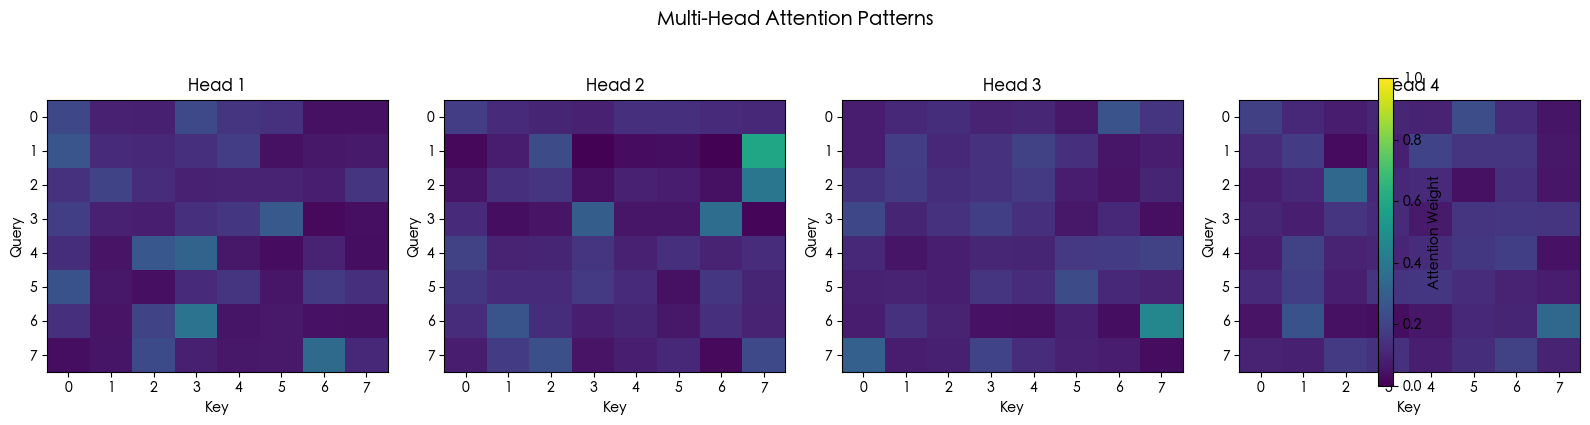


每个头学习关注不同的模式！
不同的头捕获数据中的不同关系。


In [8]:
# 创建可解释输入的注意力
seq_len = 8
d_model = 64
num_heads = 4

mha = MultiHeadAttention(d_model, num_heads)
X = np.random.randn(seq_len, d_model)
output = mha.forward(X, X, X)

# 绘制每个头的注意力模式
fig, axes = plt.subplots(1, num_heads, figsize=(16, 4))

for i, ax in enumerate(axes):
    attn = mha.attention_weights[i]
    im = ax.imshow(attn, cmap='viridis', aspect='auto', vmin=0, vmax=1)
    ax.set_title(f'Head {i+1}')
    ax.set_xlabel('Key')
    ax.set_ylabel('Query')
    
plt.colorbar(im, ax=axes, label='Attention Weight', fraction=0.046, pad=0.04)
plt.suptitle('Multi-Head Attention Patterns', fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

print("\n每个头学习关注不同的模式！")
print("不同的头捕获数据中的不同关系。")

## 自回归模型的因果（掩码）自注意力

/var/folders/dw/hbbs83sx6712jbmv2twww9nm0000gn/T/ipykernel_63882/3566598927.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


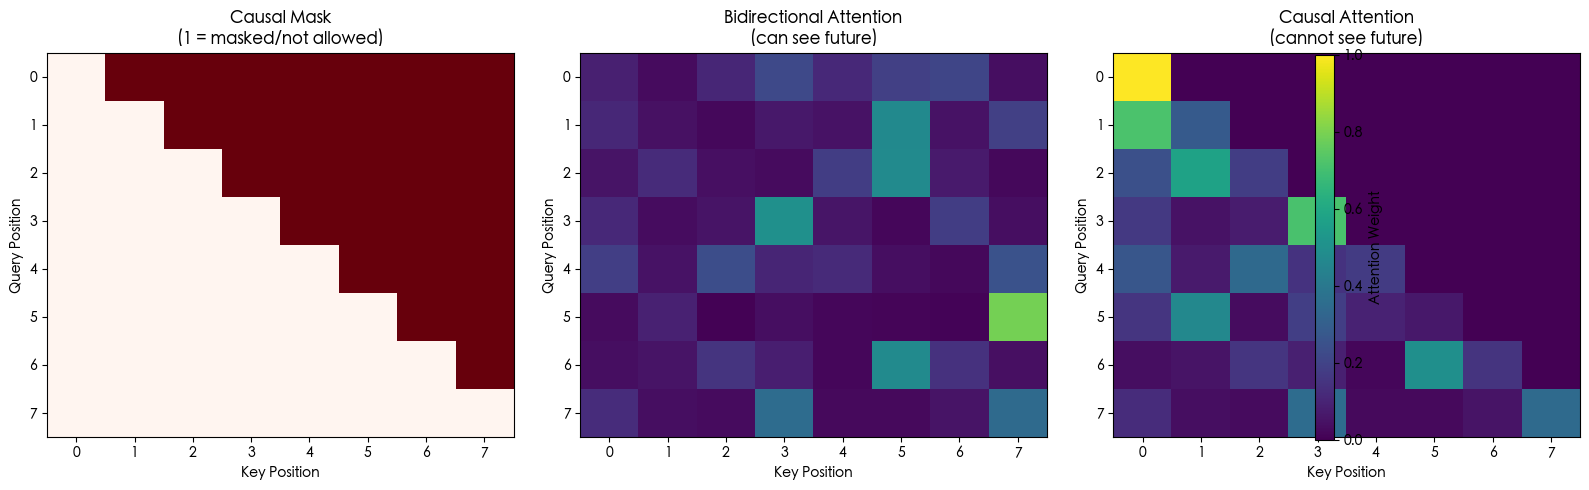


因果掩码对于以下情况至关重要：
  - 自回归生成（GPT、语言模型）
  - 防止来自未来 token 的信息泄露
  - 每个位置只能关注自身和之前的位置


In [9]:
def create_causal_mask(seq_len):
    """创建掩码以防止关注未来位置"""
    mask = np.triu(np.ones((seq_len, seq_len)), k=1)
    return mask

# 测试因果注意力
seq_len = 8
causal_mask = create_causal_mask(seq_len)

Q = np.random.randn(seq_len, d_model)
K = np.random.randn(seq_len, d_model)
V = np.random.randn(seq_len, d_model)

# 无掩码（双向）
output_bi, attn_bi = scaled_dot_product_attention(Q, K, V)

# 带因果掩码（单向）
output_causal, attn_causal = scaled_dot_product_attention(Q, K, V, mask=causal_mask)

# 可视化差异
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

# 因果掩码
ax1.imshow(causal_mask, cmap='Reds', aspect='auto')
ax1.set_title('Causal Mask\n(1 = masked/not allowed)')
ax1.set_xlabel('Key Position')
ax1.set_ylabel('Query Position')

# 双向注意力
im2 = ax2.imshow(attn_bi, cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax2.set_title('Bidirectional Attention\n(can see future)')
ax2.set_xlabel('Key Position')
ax2.set_ylabel('Query Position')

# 因果注意力
im3 = ax3.imshow(attn_causal, cmap='viridis', aspect='auto', vmin=0, vmax=1)
ax3.set_title('Causal Attention\n(cannot see future)')
ax3.set_xlabel('Key Position')
ax3.set_ylabel('Query Position')

plt.colorbar(im3, ax=[ax2, ax3], label='Attention Weight')
plt.tight_layout()
plt.show()

print("\n因果掩码对于以下情况至关重要：")
print("  - 自回归生成（GPT、语言模型）")
print("  - 防止来自未来 token 的信息泄露")
print("  - 每个位置只能关注自身和之前的位置")

## 关键要点

### 为什么"Attention Is All You Need"？
- **无循环结构**：并行处理整个序列
- **无卷积**：纯注意力机制
- **更好的扩展性**：O(n²d) vs RNN 的 O(n) 顺序操作
- **长距离依赖**：任意位置之间的直接连接

### 核心组件：
1. **缩放点积注意力**：高效的注意力计算
2. **多头注意力**：多个表示子空间
3. **位置编码**：注入位置信息
4. **前馈网络**：逐位置变换
5. **层归一化**：稳定训练
6. **残差连接**：使深度网络成为可能

### 架构变体：
- **Encoder-Decoder**：原始 Transformer（翻译）
- **仅 Encoder**：BERT（双向理解）
- **仅 Decoder**：GPT（自回归生成）

### 优势：
- 可并行化训练（与 RNN 不同）
- 更好的长距离依赖
- 可解释的注意力模式
- 在多项任务上达到最先进水平

### 影响：
- 现代 NLP 的基础：GPT、BERT、T5 等
- 扩展到视觉：Vision Transformer (ViT)
- 多模态模型：CLIP、Flamingo
- 使具有数十亿参数的 LLM 成为可能